# DallE-Mini Text to Image 
In this notebook, you'll be guided through the setup process for dalle-mini, jax, and other necessary components without relying on the cached requirements of hugging-face, weights, or bias. This means that you'll be able to run this application on any machine and generate images from given prompts with runtime support.

## Environment set up and verification



In [5]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


### GPU Set up

Import Jax

In [6]:
import jax
import jax.numpy as jnp

In Google Colab select Runtime > Change Runtime Type> GPU. Validate if GPU is loaded properly

In [7]:
jax.local_device_count()

1

In [8]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

## Install and Import all AI model components

### Install DALLE-mini

In [9]:
!pip install -q dalle-mini

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.7 MB/s eta 0:00:0

### Install Jax's version of the VQGan

In [10]:
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

  Preparing metadata (setup.py) ... done


Import all model components

In [11]:
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

### Import Hugging Face Library - already installed on Google Colab

In [12]:
from huggingface_hub import hf_hub_url, cached_download, hf_hub_download

#### Download all DallE-mini files from hugging face.  
Files are listed at the following link:

https://huggingface.co/dalle-mini/dalle-mini/tree/main

Note: All files will be saved locally.

In [13]:
import shutil

In [14]:
dalle_mini_file_list = ['config.json', 'enwiki-words-frequency.txt', 
                         'flax_model.msgpack', 'merges.txt', 
                         'special_tokens_map.json', 'tokenizer.json', 
                         'tokenizer_config.json', 'vocab.json']

In [15]:
for file in dalle_mini_file_list:
  # downloaded to local hugging face cache folder
  downloaded_file = hf_hub_download('dalle-mini/dalle-mini', filename = file)
  target_path = 'dalle-mini/' + file
  # copies files from the cache folder to the local dalle-mini folder
  # removes dependency on library cache - allows us to run anywhere
  # (e.g. refernce from our API)
  file = open(file, 'w+')
  shutil.copy(downloaded_file, target_path)


Validate files successfully downloaded and we are using local file versions (not symlinks - when loaded models, symlinks do not work)

In [16]:
!ls -lah dalle-mini

total 1.7G
-rw------- 1 root root 1.3K Feb 20 07:53 config.json
-rw------- 1 root root  33M Feb 20 07:53 enwiki-words-frequency.txt
-rw------- 1 root root 1.7G Feb 20 07:55 flax_model.msgpack
-rw------- 1 root root 450K Feb 20 07:55 merges.txt
-rw------- 1 root root  239 Feb 20 07:55 special_tokens_map.json
-rw------- 1 root root  497 Feb 20 07:55 tokenizer_config.json
-rw------- 1 root root 2.1M Feb 20 07:55 tokenizer.json
-rw------- 1 root root 783K Feb 20 07:55 vocab.json


### Retrieve all VQGAN files from hugging face
Files are listed at the following link: 

https://huggingface.co/dalle-mini/vqgan_imagenet_f16_16384/tree/main

In [17]:
vqgan_file_list = ['config.json', 'flax_model.msgpack']

In [22]:
for file in vqgan_file_list:
  # downloaded to local hugging face cache folder
  downloaded_file = hf_hub_download('dalle-mini/vqgan_imagenet_f16_16384', filename = file)
  target_path = 'dalle-mini/vqgan/' + file
  # copies files from the cache folder to the local dalle-mini folder
  # removes dependency on library cache - allows us to run anywhere
  # (e.g. refernce from our API)
  file = open(file, 'w+')
  shutil.copy(downloaded_file, target_path)

Validate files successfully downloaded and we are using local file versions

In [23]:
!ls -lah dalle-mini/vqgan

total 291M
-rw------- 1 root root  434 Feb 20 07:56 config.json
-rw------- 1 root root 291M Feb 20 07:56 flax_model.msgpack


## Load Models

### Load DallE-mini model

uses flax_model.msgpack and config.json files

In [24]:
DALLE_MODEL_PATH = 'dalle-mini'
DALLE_COMMIT_ID = None
dalle_model, dalle_params = DalleBart.from_pretrained(
    DALLE_MODEL_PATH, revision = DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False,
)
# ensure model is not initialized: _do_init

Validate DallE-mini Model

In [25]:
dalle_model

In [26]:
dalle_model.config

DalleBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "eBart"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 16385,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 2730,
  "decoder_layers": 12,
  "decoder_start_token_id": 16384,
  "do_sample": true,
  "dropout": 0.0,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 2730,
  "encoder_layers": 12,
  "encoder_vocab_size": 50264,
  "eos_token_id": 16385,
  "force_ln_scale": false,
  "gradient_checkpointing": true,
  "image_length": 256,
  "image_vocab_size": 16384,
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "ln_positions": "normformer",
  "ln_type": "layernorm",
  "max_length": 257,
  "max_text_length": 64,
  "min_length": 257,
  "model_type": "dallebart",
  "normalize_text": true,
  "pad_token_id": 16385,
  "scale_embedding": false,
  "sinkhorn_iters": 1,
  "tau_init": 0.05,
  "tie_word_embeddings": false,
  "transformers_version": "4.25.1",
  "us

In [ ]:
# View model params - comment out to save space on jupyter notebook
# dalle_params

### Load VQGAN Model

In [27]:
VQGAN_MODEL_PATH = 'dalle-mini/vqgan'
VQGAN_COMMIT_ID = None
vqgan_model, vqgan_params = VQModel.from_pretrained(
    VQGAN_MODEL_PATH, revision = VQGAN_COMMIT_ID, dtype=jnp.float16, _do_init=False,
)

Validate VQGAN Model

In [28]:
vqgan_model.config

VQGANConfig {
  "architectures": [
    "del"
  ],
  "attn_resolutions": [
    16
  ],
  "ch": 128,
  "ch_mult": [
    1,
    1,
    2,
    2,
    4
  ],
  "double_z": false,
  "dropout": 0.0,
  "embed_dim": 256,
  "give_pre_end": false,
  "in_channels": 3,
  "n_embed": 16384,
  "num_res_blocks": 2,
  "num_resolutions": 5,
  "out_ch": 3,
  "resamp_with_conv": true,
  "resolution": 256,
  "transformers_version": "4.25.1",
  "z_channels": 256
}

In [ ]:
#vqgan_params #comment out to save space on jupyter notebook

### Load DallE Bart Processor

uses downloaded files related with tokenization

In [30]:
# use the same paths as dalle-mini
DALLE_MODEL_PATH = 'dalle-mini'
DALLE_COMMIT_ID = None
dalle_bart_processor = DalleBartProcessor.from_pretrained(
    DALLE_MODEL_PATH, revision = DALLE_COMMIT_ID)



Validate DallE Bart Processor

In [31]:
dalle_bart_processor

## Multi-GPU Set-up

This set up is optional depending on what you have available to you. But a multi-GPU implementation is activated with replication.  Specifically, it will replicate parameters on all available devices.  

Note: Only one gpu is available on Google Colab.

In [32]:
from flax.jax_utils import replicate
params = replicate(dalle_params)
vqgan_params = replicate(vqgan_params)

## Model Inference
### Encode text to Images

Use partial class to parallelize given functions

In [33]:
from functools import partial

Use the main DallE-mini model to generate or  encode images i.e. pass in the tokenized prompt and encode them into images.

In [34]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums =(3,4,5,6))
def p_generate(tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale):
  return dalle_model.generate(
      **tokenized_prompt, 
      prng_key=key,
      params = params,
      top_k = top_k,
      top_p = top_p,
      temperature = temperature,
      condition_scale= condition_scale,
  )

### Decode Images

In [35]:
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
  return vqgan_model.decode_code(indices, params=params)


### Exercise Encoder Decoder Pipeline

Create example text input prompt

In [73]:
prompt = ['rainy paris']
# Process prompts with bart
tokenized_prompts = dalle_bart_processor(prompt)

Distribute tokenized prompts across multiple gpu devices

In [74]:
tokenized_prompt = replicate(tokenized_prompts)
print(tokenized_prompt)

{'attention_mask': ShardedDeviceArray([[[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]],                   dtype=int32), 'attention_mask_uncond': ShardedDeviceArray([[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]],                   dtype=int32), 'input_ids': ShardedDeviceArray([[[    0, 20238,  2358,     2,     1,     1,     1,
                          1,     1,     1,     1,     1,     1,     1,
                          1,     1,     1,     1,     1,     1,     1,
                          1,     1,     1,     1,     1,     1,     1,
                          1, 

#### Defining Model Parameters

##### Random Key Parameter

In [75]:
import random

#create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

In [76]:
# number of predictions (images) per prompt
num_predictions = 1

##### Customize Generation Paramaters
* Resource: https://huggingface.co/blog/how-to-generate

In [77]:
gen_top_k = None
gen_top_p = None
temperature = None
#conditioning scale
cond_scale = 10.0


#### Generate Images

In [78]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

In [79]:
print(f"Prompts: {prompt}")

Prompts: ['rainy paris']


  0%|          | 0/1 [00:00<?, ?it/s]

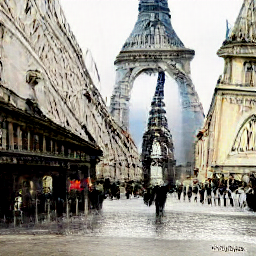

In [80]:
images = []
#device count = 1
for i in trange(max(num_predictions // jax.device_count(), 1)):
  # generate a new key
  key, subkey = jax.random.split(key)

  # Encoder
  # generate images 
  encoded_images = p_generate(
      tokenized_prompt,
      shard_prng_key(subkey),
      params,
      gen_top_k,
      gen_top_p,
      temperature,
      cond_scale,
  )

  # remove beginning of sequence
  encoded_images = encoded_images.sequences[..., 1:]

  # Decoder
  # decode images
  decoded_images = p_decode(encoded_images, vqgan_params)

  # Clip method - select top images
  decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1,256, 256,3))

  # convert images to numpy array in order to display the images
  for decoded_img in decoded_images:
    img = Image.fromarray(np.asarray(decoded_img * 255, dtype = np.uint8))
    images.append(img)
    display(img)
    print()

  